### Plasma Sheath, Cylindrical Langmuir Probe, Radial model

First, we set the kind of plasma. Uncomment the line that corresponds

In [1]:
import initialize

bg = initialize.BetaGammaSheath()
bg.x_array = []
bg.y_array = []
bg.z_array = []
bg.N_array = []

Positive ion mass = 39.948 and Negative ion mass = 0.00054858


Button(description='Run calculation', style=ButtonStyle())

Button(description='Plot results', style=ButtonStyle())

Text(value='')

<IPython.core.display.Javascript object>


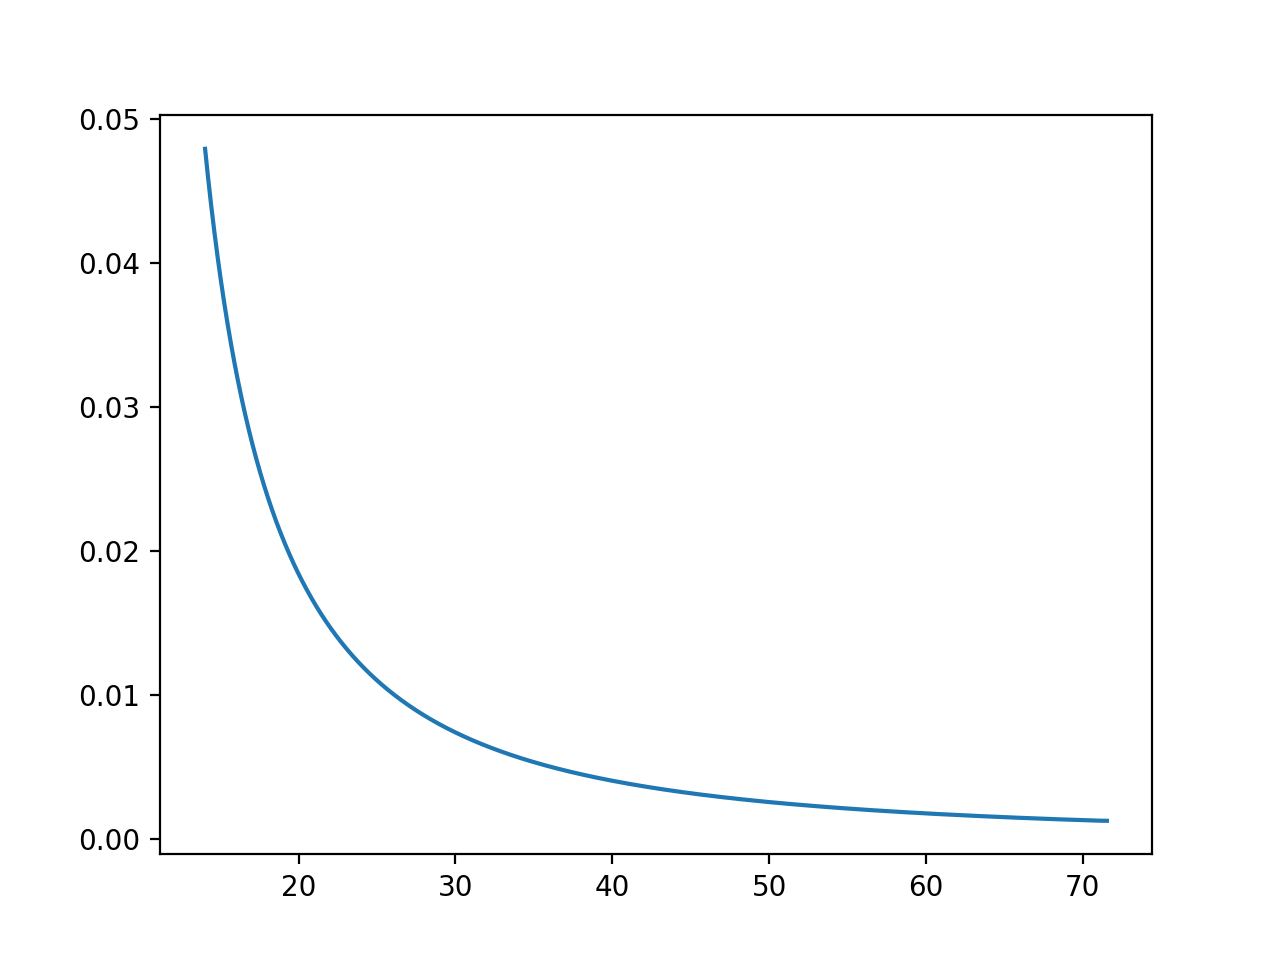

In [2]:
import sheath
from ipywidgets import widgets
import matplotlib.pyplot as plt
%matplotlib notebook

run_button = widgets.Button(description = "Run calculation")
display(run_button)

plot_button = widgets.Button(description = "Plot results")
display(plot_button)

info_text = widgets.Text()
display(info_text)

fig, ax = plt.subplots()  # Create a figure containing a single axes.

def run_button_clicked(b):
    '''Helper function to pass arguments'''
    info_text.value = "Calculation in progress"
    global bg
    sheath.cylindrical(bg)
    info_text.value = "Calculation finished"

run_button.on_click(run_button_clicked)

def plot_button_clicked(b):
    ax.plot(bg.x_array, bg.y_array)
    
plot_button.on_click(plot_button_clicked)


In [3]:
print("Positive ion mass = {0} and Negative ion mass = {1}".format(bg.p.A, bg.p.B))

Positive ion mass = 39.948 and Negative ion mass = 0.00054858
